In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


In [2]:
dataset = pd.read_csv("cumulative_2025.10.01_09.32.22.csv", sep = ",", header = 53)
dataset.head()

,kepid,kepoi_name,kepler_name,koi_disposition,koi_pdisposition,koi_score,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,...,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag
0,10797460,K00752.01,Kepler-227 b,CONFIRMED,CANDIDATE,1.000,0,0,0,0,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
1,10797460,K00752.02,Kepler-227 c,CONFIRMED,CANDIDATE,0.969,0,0,0,0,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
2,10811496,K00753.01,NaN,CANDIDATE,CANDIDATE,0.000,0,0,0,0,...,-176.0,4.544,0.044,-0.176,0.868,0.233,-0.078,297.00482,48.134129,15.436
3,10848459,K00754.01,NaN,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,0,0,...,-174.0,4.564,0.053,-0.168,0.791,0.201,-0.067,285.53461,48.285210,15.597
4,10854555,K00755.01,Kepler-664 b,CONFIRMED,CANDIDATE,1.000,0,0,0,0,...,-211.0,4.438,0.070,-0.210,1.046,0.334,-0.133,288.75488,48.226200,15.509


All the object variables are names, parsing to str

In [3]:
dataset.dtypes

kepid                  int64
kepoi_name            object
kepler_name           object
koi_disposition       object
koi_pdisposition      object
koi_score            float64
koi_fpflag_nt          int64
koi_fpflag_ss          int64
koi_fpflag_co          int64
koi_fpflag_ec          int64
koi_period           float64
koi_period_err1      float64
koi_period_err2      float64
koi_time0bk          float64
koi_time0bk_err1     float64
koi_time0bk_err2     float64
koi_impact           float64
koi_impact_err1      float64
koi_impact_err2      float64
koi_duration         float64
koi_duration_err1    float64
koi_duration_err2    float64
koi_depth            float64
koi_depth_err1       float64
koi_depth_err2       float64
koi_prad             float64
koi_prad_err1        float64
koi_prad_err2        float64
koi_teq              float64
koi_teq_err1         float64
koi_teq_err2         float64
koi_insol            float64
koi_insol_err1       float64
koi_insol_err2       float64
koi_model_snr 

In [4]:
for col in dataset.columns:
    if dataset[col].dtype == "object":
        dataset[col] = dataset[col].astype(str)

Looking for NaN

In [5]:
nan_counts = dataset.isna().sum()
nan_percent = (nan_counts / len(dataset)) * 100

for col in dataset.columns:
    print(f"{col}: {nan_counts[col]} NaN; {nan_percent[col]:.2f}%")

kepid: 0 NaN; 0.00%
kepoi_name: 0 NaN; 0.00%
kepler_name: 0 NaN; 0.00%
koi_disposition: 0 NaN; 0.00%
koi_pdisposition: 0 NaN; 0.00%
koi_score: 1510 NaN; 15.79%
koi_fpflag_nt: 0 NaN; 0.00%
koi_fpflag_ss: 0 NaN; 0.00%
koi_fpflag_co: 0 NaN; 0.00%
koi_fpflag_ec: 0 NaN; 0.00%
koi_period: 0 NaN; 0.00%
koi_period_err1: 454 NaN; 4.75%
koi_period_err2: 454 NaN; 4.75%
koi_time0bk: 0 NaN; 0.00%
koi_time0bk_err1: 454 NaN; 4.75%
koi_time0bk_err2: 454 NaN; 4.75%
koi_impact: 363 NaN; 3.80%
koi_impact_err1: 454 NaN; 4.75%
koi_impact_err2: 454 NaN; 4.75%
koi_duration: 0 NaN; 0.00%
koi_duration_err1: 454 NaN; 4.75%
koi_duration_err2: 454 NaN; 4.75%
koi_depth: 363 NaN; 3.80%
koi_depth_err1: 454 NaN; 4.75%
koi_depth_err2: 454 NaN; 4.75%
koi_prad: 363 NaN; 3.80%
koi_prad_err1: 363 NaN; 3.80%
koi_prad_err2: 363 NaN; 3.80%
koi_teq: 363 NaN; 3.80%
koi_teq_err1: 9564 NaN; 100.00%
koi_teq_err2: 9564 NaN; 100.00%
koi_insol: 321 NaN; 3.36%
koi_insol_err1: 321 NaN; 3.36%
koi_insol_err2: 321 NaN; 3.36%
koi_model_sn

Drop the columns that have a lot of nulls

In [6]:
dataset.drop(columns=["kepler_name", "koi_teq_err1", "koi_teq_err2"], inplace=True)

Montecarlo simulation to errase the NaN

In [7]:
for col in dataset.columns:
    if dataset[col].dtype in ["int64", "float64"]:
        if dataset[col].isna().sum() > 0:
            mean = dataset[col].mean()
            std = dataset[col].std()
            # Generem valors aleatoris
            random_values = np.random.normal(mean, std, size=dataset[col].isna().sum())
            dataset.loc[dataset[col].isna(), col] = random_values


Looking at the data again

In [8]:
dataset.head()

,kepid,kepoi_name,koi_disposition,koi_pdisposition,koi_score,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,koi_period,...,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag
0,10797460,K00752.01,CONFIRMED,CANDIDATE,1.000,0,0,0,0,9.488036,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
1,10797460,K00752.02,CONFIRMED,CANDIDATE,0.969,0,0,0,0,54.418383,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
2,10811496,K00753.01,CANDIDATE,CANDIDATE,0.000,0,0,0,0,19.899140,...,-176.0,4.544,0.044,-0.176,0.868,0.233,-0.078,297.00482,48.134129,15.436
3,10848459,K00754.01,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,0,0,1.736952,...,-174.0,4.564,0.053,-0.168,0.791,0.201,-0.067,285.53461,48.285210,15.597
4,10854555,K00755.01,CONFIRMED,CANDIDATE,1.000,0,0,0,0,2.525592,...,-211.0,4.438,0.070,-0.210,1.046,0.334,-0.133,288.75488,48.226200,15.509


The variables koi_disposition and koi_pdisposition seem the same

In [9]:
for i, row in dataset.iterrows():
    if row["koi_disposition"] != row["koi_pdisposition"]:
         print(f'#{i}: {row["koi_disposition"]} - {row["koi_pdisposition"]}')

#0: CONFIRMED - CANDIDATE
#1: CONFIRMED - CANDIDATE
#4: CONFIRMED - CANDIDATE
#5: CONFIRMED - CANDIDATE
#6: CONFIRMED - CANDIDATE
#7: CONFIRMED - CANDIDATE
#9: CONFIRMED - CANDIDATE
#10: CONFIRMED - CANDIDATE
#11: CONFIRMED - CANDIDATE
#12: CONFIRMED - CANDIDATE
#13: CONFIRMED - CANDIDATE
#18: CONFIRMED - CANDIDATE
#19: CONFIRMED - CANDIDATE
#21: CONFIRMED - CANDIDATE
#22: CONFIRMED - CANDIDATE
#23: CONFIRMED - CANDIDATE
#25: CONFIRMED - CANDIDATE
#26: CONFIRMED - CANDIDATE
#27: CONFIRMED - CANDIDATE
#31: CONFIRMED - CANDIDATE
#32: CONFIRMED - CANDIDATE
#33: CONFIRMED - CANDIDATE
#34: CONFIRMED - CANDIDATE
#35: CONFIRMED - CANDIDATE
#36: CONFIRMED - CANDIDATE
#37: CONFIRMED - CANDIDATE
#39: CONFIRMED - CANDIDATE
#41: CONFIRMED - CANDIDATE
#42: CONFIRMED - CANDIDATE
#43: CONFIRMED - CANDIDATE
#44: CONFIRMED - CANDIDATE
#45: CONFIRMED - CANDIDATE
#47: CONFIRMED - CANDIDATE
#48: CONFIRMED - CANDIDATE
#49: CONFIRMED - CANDIDATE
#50: CONFIRMED - CANDIDATE
#51: CONFIRMED - CANDIDATE
#52: CON

In [10]:
for i, row in dataset.iterrows():
    if row["koi_disposition"] != row["koi_pdisposition"] and row["koi_disposition"] != "CONFIRMED" and row["koi_pdisposition"] != "CANDIDATE":
         print(f'#{i}: {row["koi_disposition"]} - {row["koi_pdisposition"]}')

In [11]:
dataset.drop(columns = ["koi_pdisposition"], inplace=True)

## Variables

In [12]:
num_cols = dataset.select_dtypes(include=[np.number]).columns

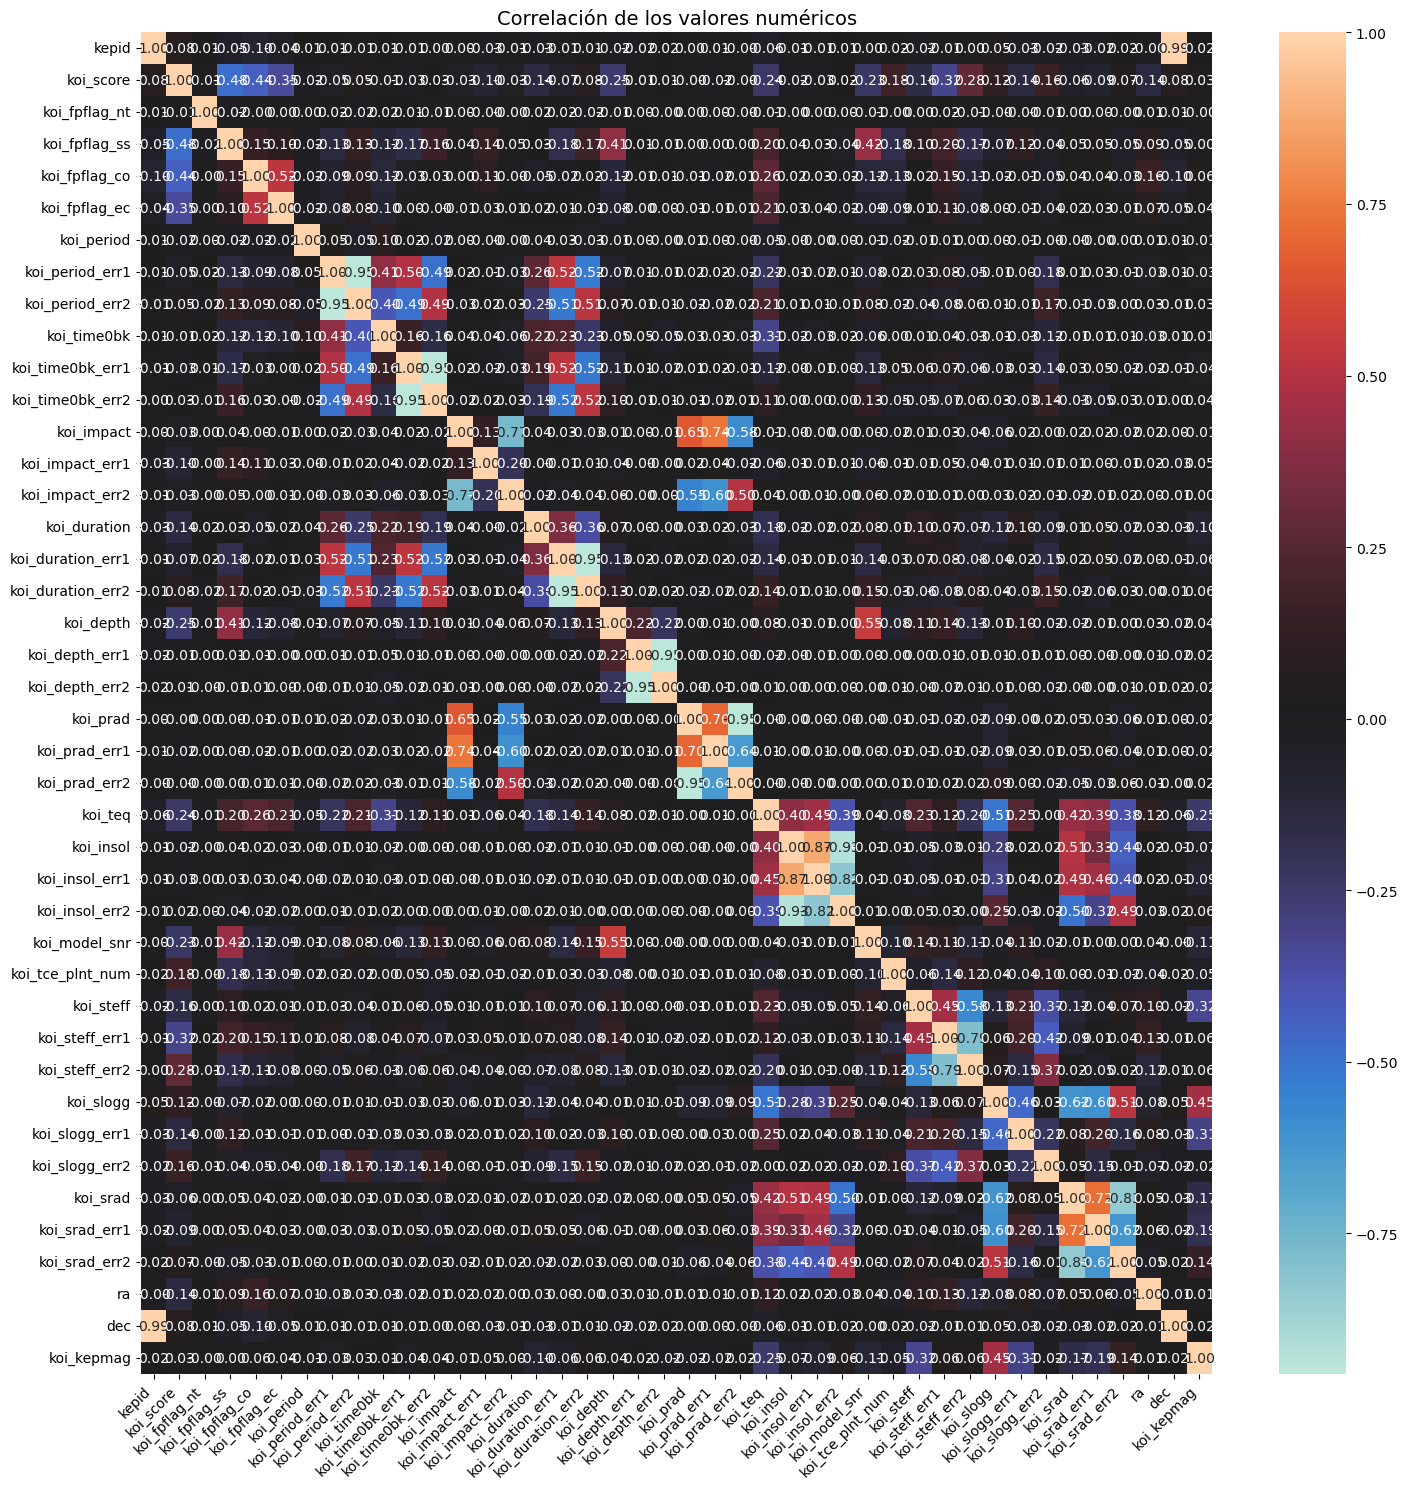

In [13]:
# Calcular correlació de les columnes numèriques
correlation = dataset[num_cols].corr()

# Heatmap
plt.figure(figsize=(15, 15))
sns.heatmap(
    correlation,
    annot=True,         # mostra valors
    cmap="icefire",     # esquema de colors
    fmt=".2f",          # format dels números
    cbar=True
)
plt.title("Correlación de los valores numéricos", fontsize=14)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


kpi_insol with koi_insol_err1
kpi_prad_err1 with koi_impact
koi_stand_err1 with koi_srad

In [14]:
dataset.drop(columns=["kepid", "koi_insol", "koi_prad_err1", "koi_srad_err1"], inplace=True)
num_cols = num_cols.drop(["kepid", "koi_insol", "koi_prad_err1", "koi_srad_err1"])

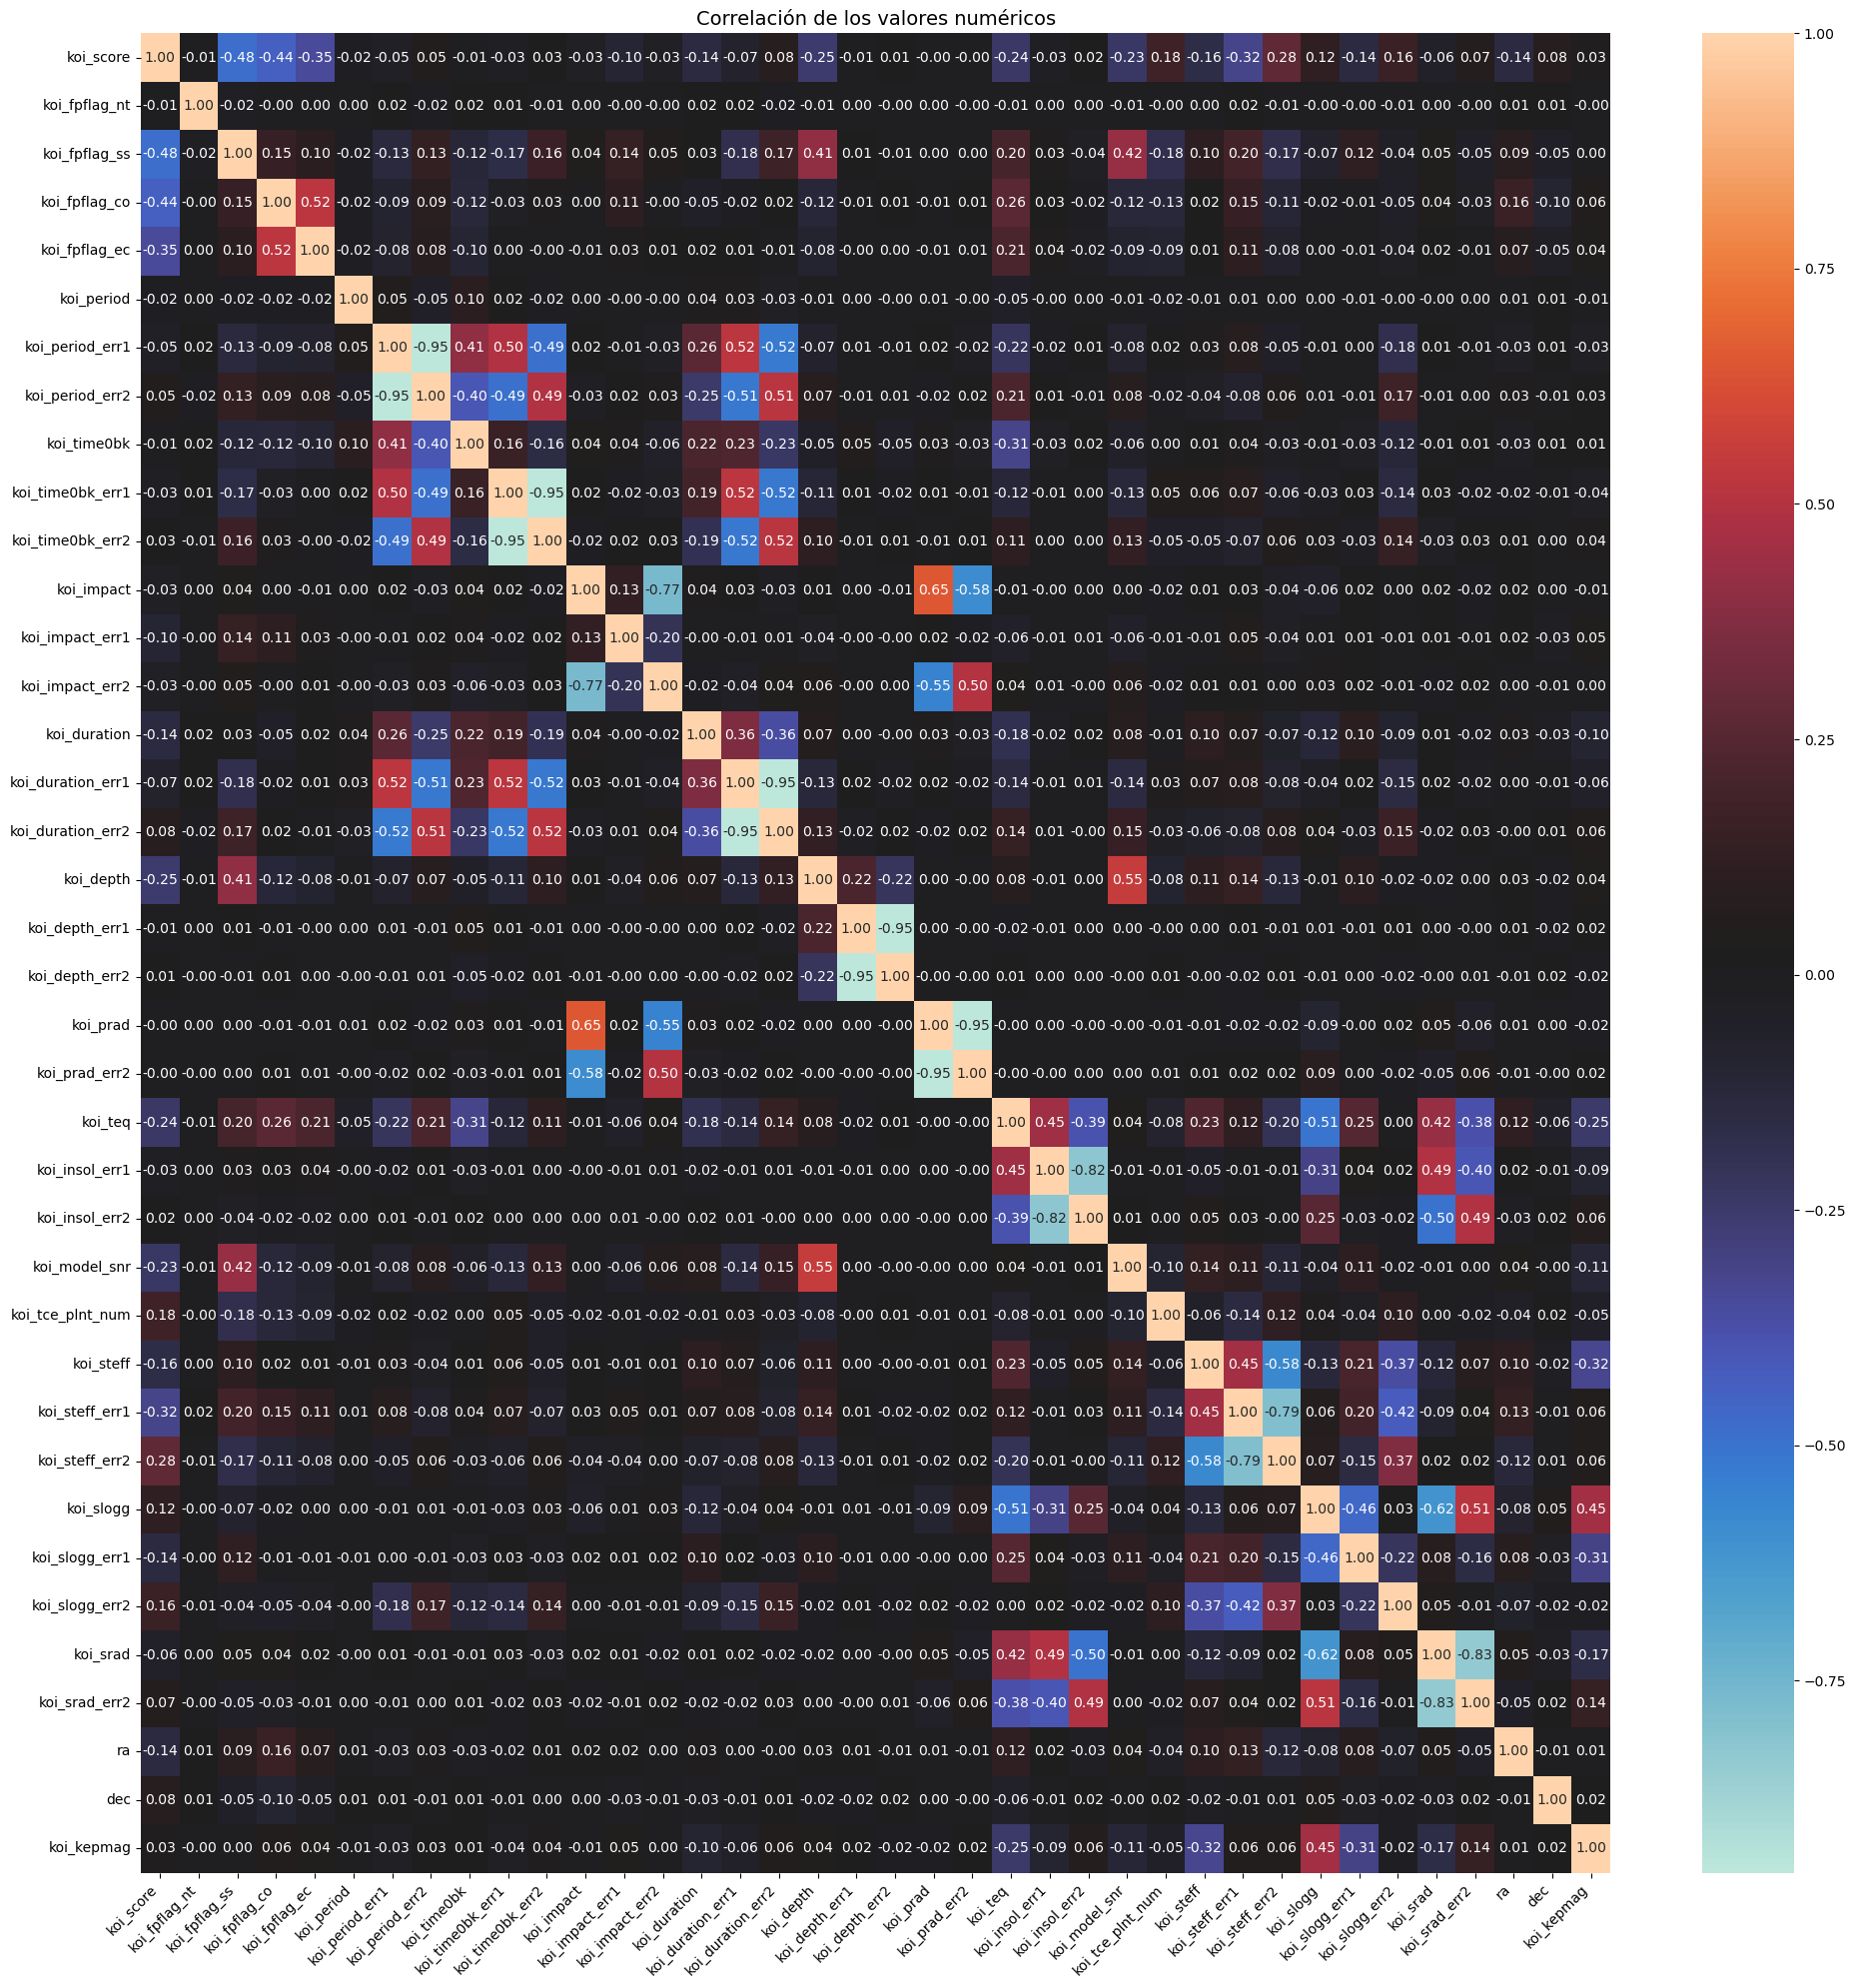

In [15]:
# Calcular correlació de les columnes numèriques
correlation = dataset[num_cols].corr()

# Heatmap
plt.figure(figsize=(20, 20))
sns.heatmap(
    correlation,
    annot=True,         # mostra valors
    cmap="icefire",     # esquema de colors
    fmt=".2f",          # format dels números
    cbar=True
)
plt.title("Correlación de los valores numéricos", fontsize=14)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


## PCA

In [16]:
X = dataset[num_cols]

# Escalem les dades (molt important en PCA)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [17]:
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

In [18]:
# print("Eigenvalues:", pca.explained_variance_)

# print("Explained variance ratio:", pca.explained_variance_ratio_)

# Loadings)
loadings = pd.DataFrame(
    pca.components_,
    columns=num_cols,
    index=[f"PC{i+1}" for i in range(len(num_cols))]
)
print(loadings)


      koi_score  koi_fpflag_nt  koi_fpflag_ss  koi_fpflag_co  koi_fpflag_ec  \
PC1   -0.003693       0.015233      -0.129792      -0.051738      -0.031930   
PC2    0.224670      -0.002963      -0.164376      -0.124325      -0.102503   
PC3   -0.258717       0.001588       0.220751       0.120448       0.101124   
PC4   -0.074584      -0.000092       0.092113       0.031913       0.017645   
PC5    0.059673      -0.002028       0.098568      -0.285896      -0.251630   
PC6   -0.229975       0.000431       0.042905       0.438639       0.407042   
PC7   -0.285634      -0.014581       0.387785       0.023111       0.027316   
PC8    0.114537       0.015515      -0.018700      -0.161336      -0.176264   
PC9   -0.053941       0.037281      -0.040891       0.080745       0.007440   
PC10   0.030308      -0.159440       0.153363      -0.067920      -0.187313   
PC11   0.034706       0.178431      -0.038229      -0.069713      -0.015895   
PC12  -0.007322       0.832796       0.019327      -

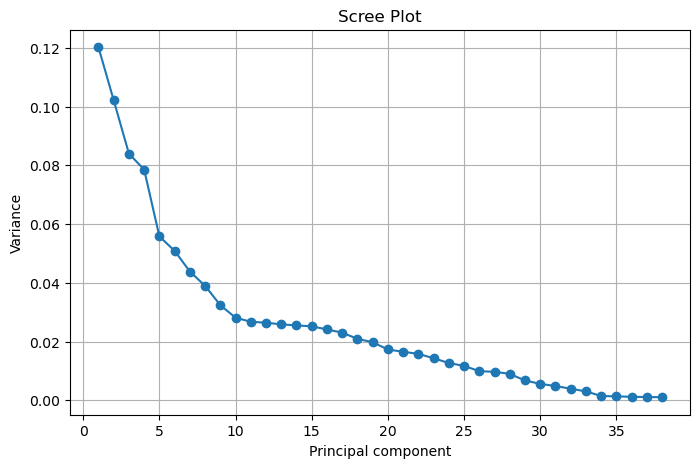

In [19]:
plt.figure(figsize=(8,5))
plt.plot(range(1, len(num_cols)+1), pca.explained_variance_ratio_, marker='o')
plt.title("Scree Plot")
plt.xlabel("Principal component")
plt.ylabel("Variance")
plt.grid(True)
plt.show()


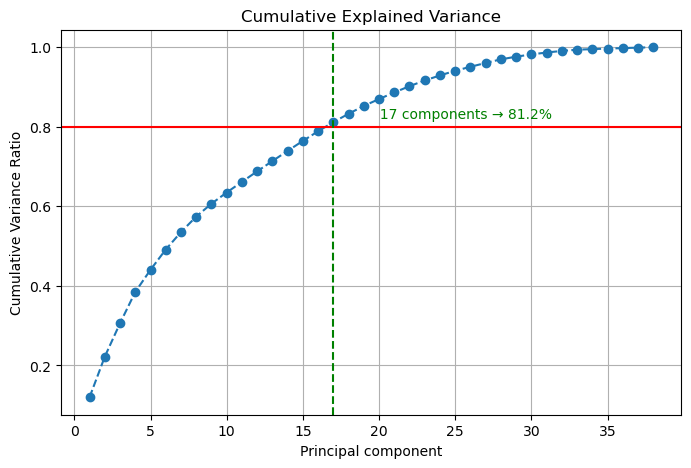

In [20]:
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Gràfic
plt.figure(figsize=(8,5))
plt.plot(range(1, len(num_cols)+1), cumulative_variance, marker='o', linestyle='--')
plt.axhline(y=0.8, color='r', linestyle='-')  # línia de tall 80%
plt.title("Cumulative Explained Variance")
plt.xlabel("Principal component")
plt.ylabel("Cumulative Variance Ratio")
plt.grid(True)

# Marcar el punt on s'arriba al 80%
n_components_80 = np.argmax(cumulative_variance >= 0.8) + 1
plt.axvline(x=n_components_80, color='g', linestyle='--')
plt.text(n_components_80+0.2, 0.82,
         f"          {n_components_80} components → {cumulative_variance[n_components_80-1]*100:.1f}%",
         color="g")

plt.show()

Getting the 17 first pca components

In [21]:
X_scaled = StandardScaler().fit_transform(dataset[num_cols])

# PCA amb 17 components
pca_17 = PCA(n_components=17)
X_pca_17 = pca_17.fit_transform(X_scaled)

# Creem un DataFrame amb els 17 components
dataset_pca = pd.DataFrame(
    X_pca_17,
    columns=[f"PC{i+1}" for i in range(17)]
)

# Models

In [22]:
target = "koi_disposition"

label_map = {
    "FALSE POSITIVE": 0,
    "CANDIDATE": 1,
    "CONFIRMED": 2
}
inv_label_map = {v: k for k, v in label_map.items()}

vals_out = set(dataset[target].unique()) - set(label_map.keys())
if vals_out:
    raise ValueError(f"Hay valores de '{target}' no mapeados: {vals_out}")

y = dataset[target].map(label_map).astype(int)

In [23]:
X_orig = dataset.select_dtypes(include=[np.number]).copy()
X_pca = dataset_pca.copy()

Xo_train, Xo_test, yo_train, yo_test = train_test_split(X_orig, y, test_size=0.2, random_state=42, stratify=y)
Xp_train, Xp_test, yp_train, yp_test = train_test_split(X_pca, y, test_size=0.2, random_state=42, stratify=y)

clf_params = dict(
    objective="multi:softprob",  # probas multiclase
    num_class=3,
    eval_metric="mlogloss",
    random_state=42,
    n_estimators=300,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8
)

model_original = xgb.XGBClassifier(**clf_params)
model_pca      = xgb.XGBClassifier(**clf_params)

model_original.fit(Xo_train, yo_train)
model_pca.fit(Xp_train, yp_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None, num_class=3, ...)

In [24]:
yo_pred = model_original.predict(Xo_test)
yp_pred = model_pca.predict(Xp_test)

print("=== XGBoost con variables originales (solo numéricas) ===")
print(f"Accuracy: {accuracy_score(yo_test, yo_pred):.4f}")
print(f"F1 (weighted): {f1_score(yo_test, yo_pred, average='weighted'):.4f}")

print("\n=== XGBoost con PCA (17 componentes) ===")
print(f"Accuracy: {accuracy_score(yp_test, yp_pred):.4f}")
print(f"F1 (weighted): {f1_score(yp_test, yp_pred, average='weighted'):.4f}")

ejemplo_labels = pd.Series(yo_pred[:5]).map(inv_label_map).tolist()
print("\nEjemplo de labels predichos (original -> strings):", ejemplo_labels)

=== XGBoost con variables originales (solo numéricas) ===
Accuracy: 0.9399
F1 (weighted): 0.9399

=== XGBoost con PCA (17 componentes) ===
Accuracy: 0.8474
F1 (weighted): 0.8437

Ejemplo de labels predichos (original -> strings): ['CONFIRMED', 'CONFIRMED', 'FALSE POSITIVE', 'FALSE POSITIVE', 'FALSE POSITIVE']


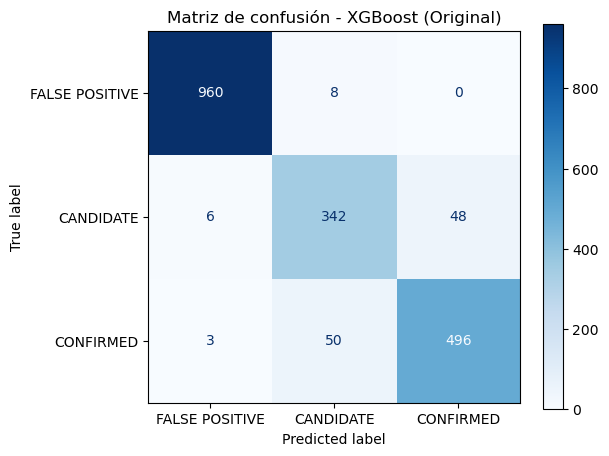

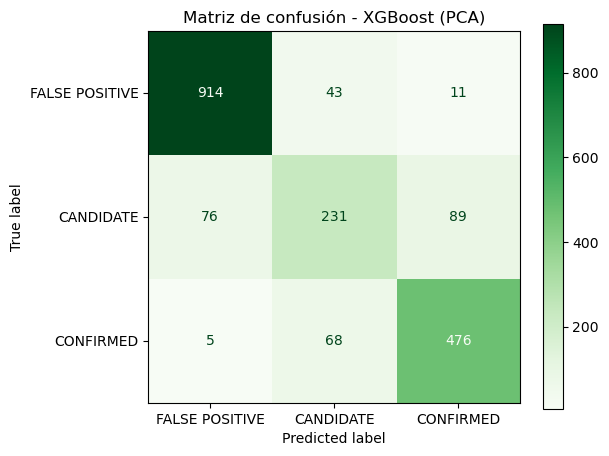

In [25]:
cm_orig = confusion_matrix(yo_test, yo_pred)
disp_orig = ConfusionMatrixDisplay(confusion_matrix=cm_orig,
                                   display_labels=[inv_label_map[i] for i in range(3)])

plt.figure(figsize=(6,5))
disp_orig.plot(cmap="Blues", values_format="d", ax=plt.gca())
plt.title("Matriz de confusión - XGBoost (Original)")
plt.show()

# === Matriu de confusió model PCA ===
cm_pca = confusion_matrix(yp_test, yp_pred)
disp_pca = ConfusionMatrixDisplay(confusion_matrix=cm_pca,
                                  display_labels=[inv_label_map[i] for i in range(3)])

plt.figure(figsize=(6,5))
disp_pca.plot(cmap="Greens", values_format="d", ax=plt.gca())
plt.title("Matriz de confusión - XGBoost (PCA)")
plt.show()


---

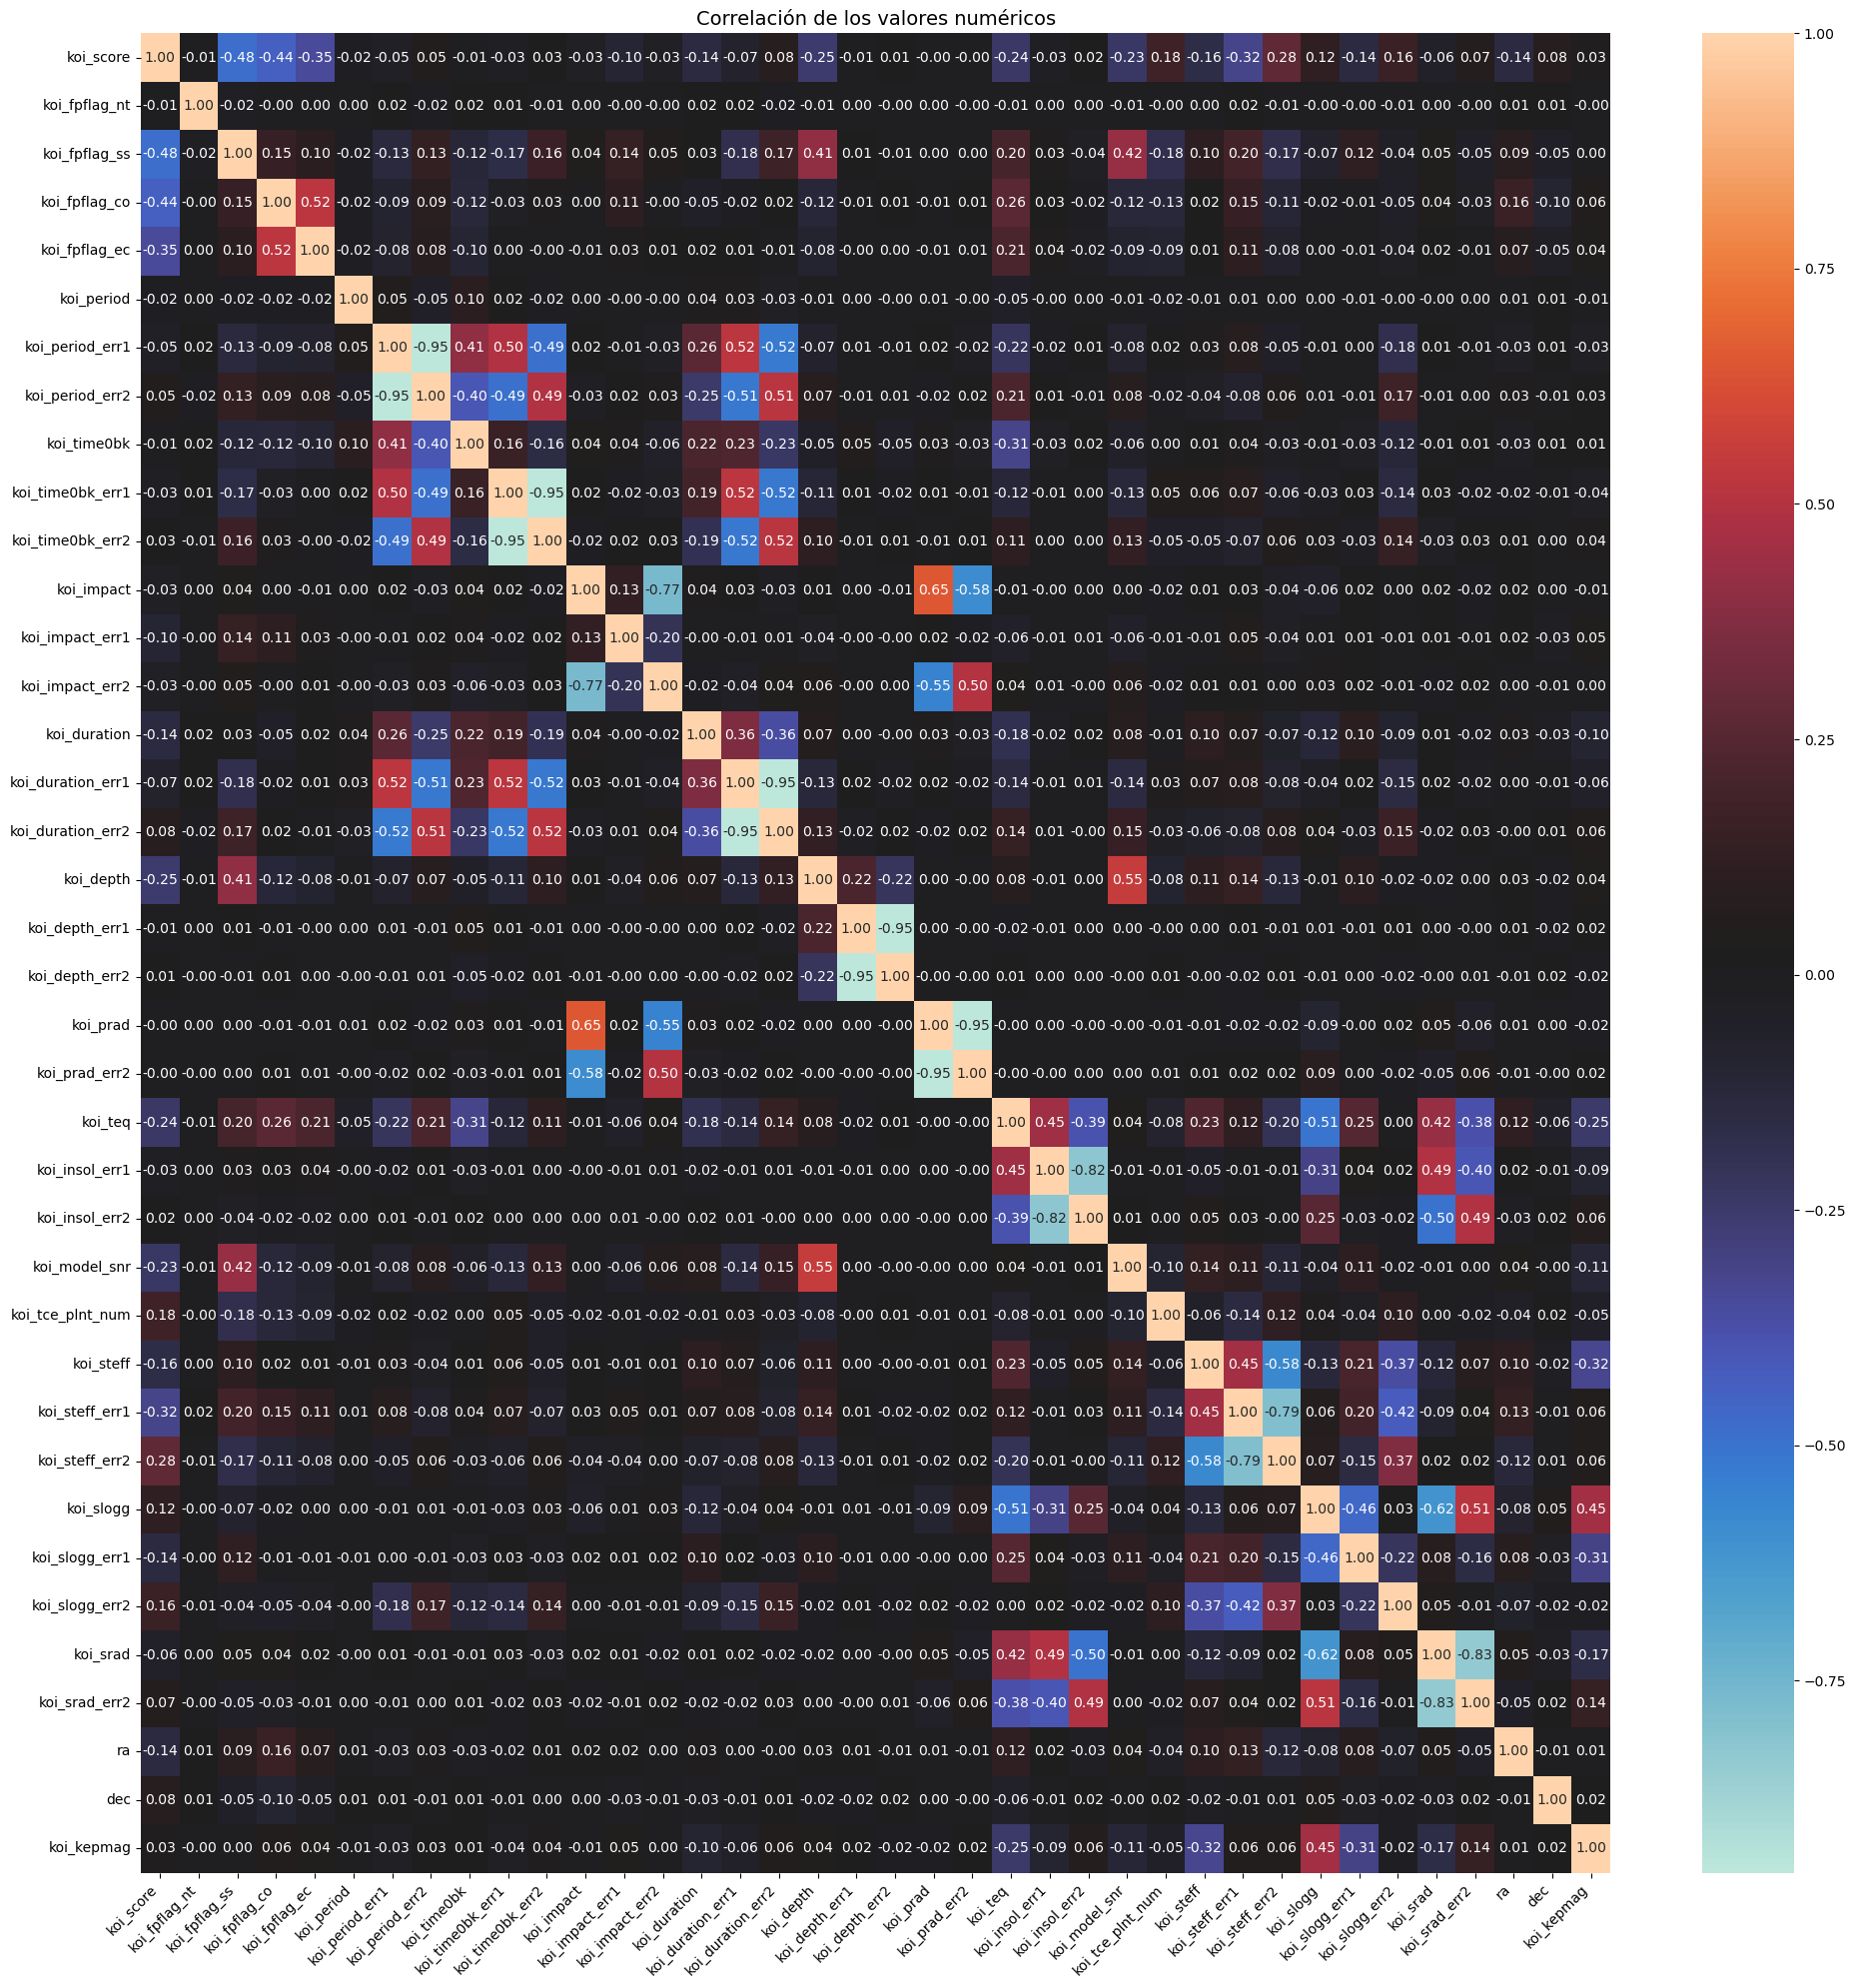

In [26]:
# Calcular correlació de les columnes numèriques
correlation = dataset[num_cols].corr()

# Heatmap
plt.figure(figsize=(20, 20))
sns.heatmap(
    correlation,
    annot=True,         # mostra valors
    cmap="icefire",     # esquema de colors
    fmt=".2f",          # format dels números
    cbar=True
)
plt.title("Correlación de los valores numéricos", fontsize=14)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


koi_srad with koi_srad_err2
koi_steff_err1 with koi_steff_err2
koi_insol_err1 with koi_insol_err2
koi_prad with koi_prad_err2
koi_depth_err1 with koi_depth_err2
koi_duration_err1 with koi_duration_err2
koi_impact with koi_impact_err2
koi_period_err1 with koi_period_err2 
koi_time0bk_err1 with koi_time0bk_err2

In [27]:
dataset.drop(columns=["koi_srad", "koi_steff_err1", "koi_insol_err1", "koi_prad", "koi_depth_err1", "koi_duration_err1", "koi_impact", "koi_period_err1", "koi_time0bk_err1"], inplace=True)
num_cols = num_cols.drop(["koi_srad", "koi_steff_err1", "koi_insol_err1", "koi_prad", "koi_depth_err1", "koi_duration_err1", "koi_impact", "koi_period_err1", "koi_time0bk_err1"])

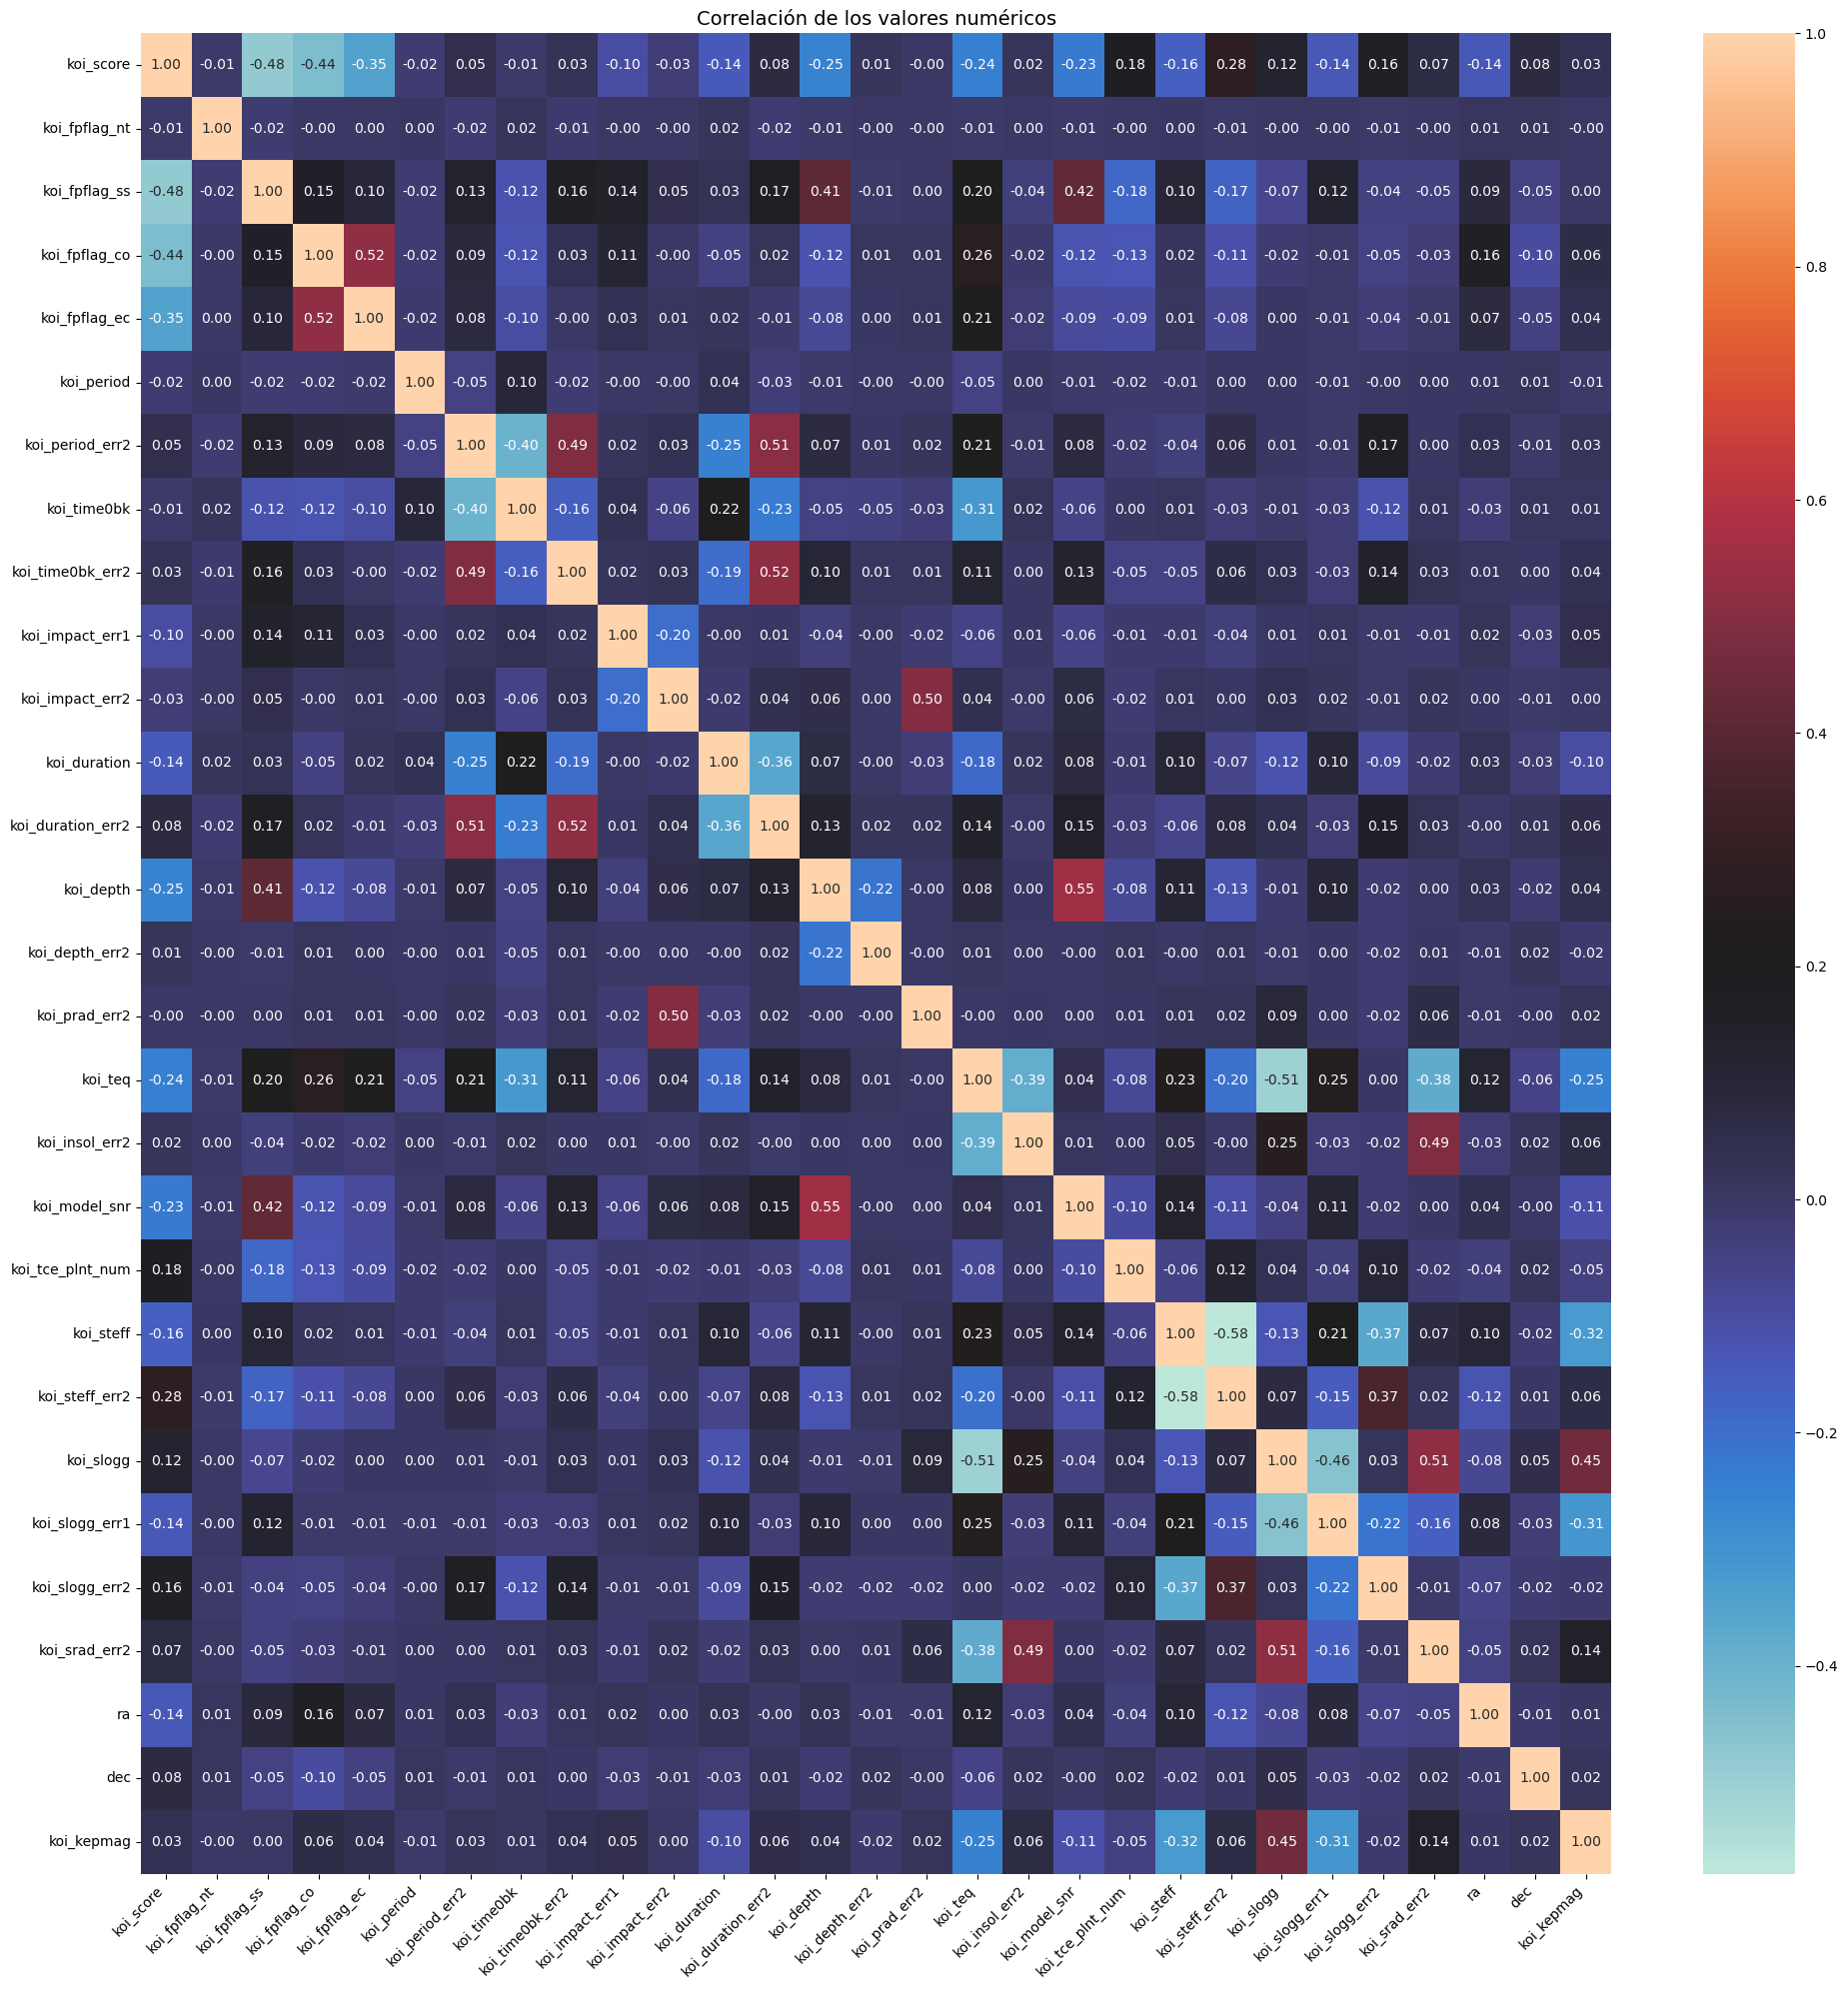

In [28]:
# Calcular correlació de les columnes numèriques
correlation = dataset[num_cols].corr()

# Heatmap
plt.figure(figsize=(20, 20))
sns.heatmap(
    correlation,
    annot=True,         # mostra valors
    cmap="icefire",     # esquema de colors
    fmt=".2f",          # format dels números
    cbar=True
)
plt.title("Correlación de los valores numéricos", fontsize=14)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [29]:
X_orig = dataset.select_dtypes(include=[np.number]).copy()

Xo_train, Xo_test, yo_train, yo_test = train_test_split(X_orig, y, test_size=0.2, random_state=42, stratify=y)

clf_params = dict(
    objective="multi:softprob",  # probas multiclase
    num_class=3,
    eval_metric="mlogloss",
    random_state=42,
    n_estimators=300,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8
)

model_original = xgb.XGBClassifier(**clf_params)

model_original.fit(Xo_train, yo_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None, num_class=3, ...)

=== XGBoost con variables originales (solo numéricas) ===
Accuracy: 0.9347
F1 (weighted): 0.9346


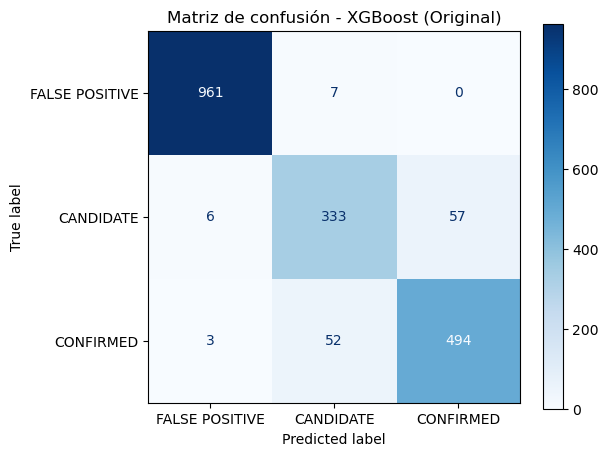

In [30]:
yo_pred = model_original.predict(Xo_test)

print("=== XGBoost con variables originales (solo numéricas) ===")
print(f"Accuracy: {accuracy_score(yo_test, yo_pred):.4f}")
print(f"F1 (weighted): {f1_score(yo_test, yo_pred, average='weighted'):.4f}")

cm_orig = confusion_matrix(yo_test, yo_pred)
disp_orig = ConfusionMatrixDisplay(confusion_matrix=cm_orig,
                                   display_labels=[inv_label_map[i] for i in range(3)])

plt.figure(figsize=(6,5))
disp_orig.plot(cmap="Blues", values_format="d", ax=plt.gca())
plt.title("Matriz de confusión - XGBoost (Original)")
plt.show()
